In [1]:
%load_ext autoreload
%autoreload 2
%matplotlib inline

In [149]:
import pandas as pd
import numpy as np

import matplotlib
# matplotlib.use('Agg')
import matplotlib.pyplot as plt
import seaborn as sns
sns.set_context('notebook')
sns.set()

# Catalog Investigations

Motivated by mysterious bugs classifying bars with my active learning work, I took a hard look at the GZ2 catalog itself. 

**I found that the catalog is not homogenous**: galaxies higher up in the catalog (rows 0, 1, 2...) are more featured than galaxies lower down.

Below are my results. The catalog is `gz2_hart16.csv`, as published on data.galaxyzoo.org, with a few extra columns added.

What's going on?

#### Load Catalog

In [150]:
gz2_catalog_loc = '/data/galaxy_zoo/gz2/catalogs/gz2_classifications_and_subjects.csv'  # replace this with your own catalog if desired
catalog = pd.read_csv(gz2_catalog_loc)

In [151]:
catalog.head(2)

,dr7objid,ra_subject,dec_subject,rastring,decstring,sample,gz2_class,total_classifications,total_votes,t01_smooth_or_features_a01_smooth_count,...,redshift_bin,magsize_bin,battle_bin,ra,dec,stripe82,stripe82_coadd,extra_original,png_loc,png_ready
0,587732591714893851,179.042984,60.522518,11:56:10.32,+60:31:21.1,original,Sc+t,45,342,0,...,2,0,2,179.042984,60.522518,0,0,0,/Volumes/alpha/gz2/png/587732/5877325917148938...,True
1,588009368545984617,135.084396,52.494240,09:00:20.26,+52:29:39.3,original,Sb+t,42,332,1,...,2,78,78002,135.084396,52.494240,0,0,0,/Volumes/alpha/gz2/png/588009/5880093685459846...,True


### Derive Useful Columns

In [152]:
catalog['smooth-or-featured_total-votes'] = catalog['t01_smooth_or_features_a01_smooth_count'] + catalog['t01_smooth_or_features_a02_features_or_disk_count'] + catalog['t01_smooth_or_features_a03_star_or_artifact_count']
catalog['smooth-or-featured_featured-fraction'] = catalog['t01_smooth_or_features_a02_features_or_disk_count']/catalog['smooth-or-featured_total-votes']

### Where is Each Sample?

Text(0,0.5,'Galaxies')

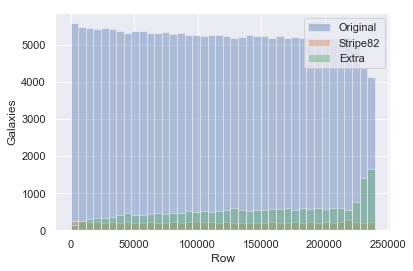

In [153]:
fig, ax = plt.subplots()
alpha = 0.4
bins = 40
extra = catalog[catalog['sample'] == 'extra']
stripe = catalog[catalog['sample'] == 'stripe82']
original = catalog[catalog['sample'] == 'original']
ax.hist(original.index, label='Original', alpha=alpha, bins=bins)
ax.hist(stripe.index, label='Stripe82', alpha=alpha, bins=bins)
ax.hist(extra.index, label='Extra', alpha=alpha, bins=bins)
ax.legend()
ax.set_xlabel('Row')
ax.set_ylabel('Galaxies')

The original sample dominates throughout, but the extra sample becomes important in the last ~20,000 rows.

For simplicity, let's look only at the original sample for now.

### How many Classifications by Row?

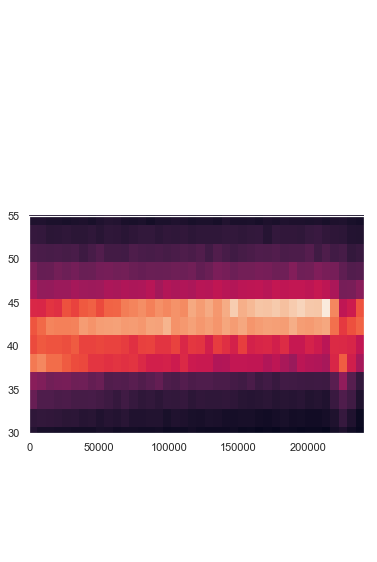

In [154]:
fig, ax = plt.subplots()
ax.hist2d(original.index, original['smooth-or-featured_total-votes'], bins=[40, 30])
ax.set_ylim([30, 55])
ax.grid(False)

In [155]:
original['smooth-or-featured_total-votes'].min(), original['smooth-or-featured_total-votes'].max()

(16, 79)

Most galaxies have ~40 responses to the first question, as expected.

Something weird is happening at the end. That's worth a discussion in it's own right, but **let's totally ignore it for now.**

Let's trim off the weird end for simplicity.
Let's also remove the handful of galaxies with wildly low vote fractions, just in case.

In [156]:
original_trimmed = original[:190000]
original_trimmed = original_trimmed[original_trimmed['smooth-or-featured_total-votes'] >= 30]
original_trimmed['smooth-or-featured_total-votes'].min(), original_trimmed['smooth-or-featured_total-votes'].max()

(30, 73)

### How Featured are the Galaxies?

(array([58690., 45246., 19809., 12045.,  9540.,  9038.,  7215.,  6808.,
         7674., 11658.]),
 array([0. , 0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9, 1. ]),
 <a list of 10 Patch objects>)

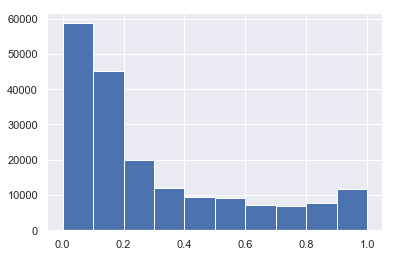

In [157]:
fig, ax = plt.subplots()
ax.hist(original_trimmed['smooth-or-featured_featured-fraction'])

So far so good. Here's where things get really weird...

### Are the Featured galaxies evenly spread throughout (spoiler: no)

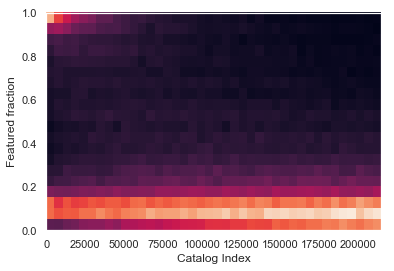

In [158]:
fig, ax = plt.subplots()

ax.hist2d(original_trimmed.index, original_trimmed['smooth-or-featured_featured-fraction'], bins=[40, 20])
ax.set_xlabel('Catalog Index')
ax.set_ylabel('Featured fraction')
ax.grid(False)

That's odd: the most featured galaxies are higher in the catalog!

Let's zoom in a bit to see the pattern better, cutting off the common smooth galaxy mode.

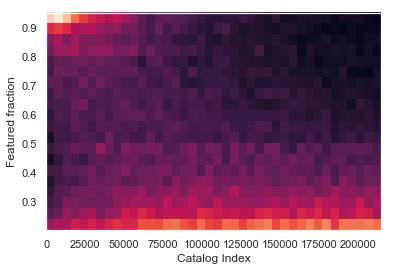

In [159]:
featured = original_trimmed[['smooth-or-featured_featured-fraction', 'smooth-or-featured_total-votes']].copy()
featured['smooth-or-featured_featured-fraction'] = featured[featured['smooth-or-featured_featured-fraction'] > 0.2]
featured['smooth-or-featured_featured-fraction'] = featured[featured['smooth-or-featured_featured-fraction'] < .95]
featured = featured.dropna()
fig, ax = plt.subplots()
_ = ax.hist2d(featured.index, featured['smooth-or-featured_featured-fraction'], bins=[40, 20])
ax.set_xlabel('Catalog Index')
ax.set_ylabel('Featured fraction')
ax.grid(False)

This is after:
    - selecting only the original sample
    - excluding the strange final rows
    - excluding galaxies with low total votes (almost all are 35-45)

**What's going on?? Help me out, science team!**